In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
import sys
from ml_template.utils import *
from ml_template.model.ml_model import *
data_df = pd.read_csv('data/train.csv',sep='\t',header=None)
test_df = pd.read_csv('data/test.csv',sep='\t',header=None)

In [2]:
data = data_df.values[:,:-1]
label=(data_df.values[:,-1]+1)//2
qt = QuantileTransformer(n_quantiles=10)
data = qt.fit_transform(data)

In [3]:
# split 9:1 
train_data, train_label, test_data, test_label = KFold_Sampler(data,label,n_splits=10).get_multi_fold_data(n_fold=1)
print(len(train_data),len(test_data),len(test_data)/(len(train_data)+len(test_data)))

# define model list
model_lgb = lgb.LGBMClassifier(is_unbalance=True)

model_dict = {'RF_3':RandomForestClassifier(n_estimators=310,max_depth=3),
              'RF_depth_None':RandomForestClassifier(n_estimators=310),
              'XGB_31_3':XGBClassifier(n_estimators=31,max_depth=3),
              'XGB_310_3':XGBClassifier(n_estimators=31,max_depth=3),
              'XGB_31':XGBClassifier(n_estimators=31),
              'XGB_310':XGBClassifier(n_estimators=310),
              'SVM':SVC(probability=True),
              'SVM_lin':SVC(kernel='linear',probability=True),
              'SVM_rbf':SVC(kernel='rbf',probability=True),
              'SVM_0.2':SVC(C=0.2,probability=True),
              'SVM_0.2_lin':SVC(C=0.2,kernel='linear',probability=True),
              'SVM_0.2_poly':SVC(C=0.2,kernel='poly',probability=True),
              'SVM_5':SVC(C=5,probability=True),
              'SVM_5_lin':SVC(C=5,kernel='linear',probability=True),
              'SVM_5_poly':SVC(C=5,kernel='poly',probability=True),
              # 'KNN_Cls':KNeighborsClassifier(),
              'LGB_Cls':model_lgb,
              # 'Ridge_Cls':RidgeClassifier(),
              # 'MLP_Cls':MLPClassifier(activation = "relu", alpha = 0.001, hidden_layer_sizes = (56,10),
              #               learning_rate = "constant", max_iter = 3000, random_state = 3000,early_stopping=True),
              # 'QDA':QuadraticDiscriminantAnalysis(),
              }
#stack_model=MLPClassifier(activation = "relu", alpha = 0.0001,validation_fraction=0.1, hidden_layer_sizes = (38),learning_rate = "constant", max_iter = 3000, random_state = 1000,early_stopping=True)
# stack_model=SVC(C=1,kernel='linear', probability=True)
#stack_model = DecisionTreeClassifier()
num_model = len(list(model_dict.keys()))
num_classes=1
stack_model=ML_Weighted_Model(num_model,
                              num_classes,
                              epoch=300,
                              model_reg=0.00,
                              classes_reg=0.00,
                              l1_norm=0.00)
model = Stack_Ensemble_Model(copy.deepcopy(model_dict),stack_model=stack_model,stack_training_split=0.2)
# model = Mean_Ensemble_Proba_Model(copy.deepcopy(model_dict))
cv_model, cv_df = model.cross_validation_evaluate(train_data, train_label, accuracy_score,n_splits=5)

90 10 0.1


Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0769],
        [1.0769],
        [0.1621],
        [0.0000],
        [1.0408],
        [0.1621],
        [1.1012]], requires_grad=True)


ValueError: Classification metrics can't handle a mix of continuous and binary targets

array([0.21666928, 0.27856308, 0.25517422, 0.25517422, 0.4612457 ,
       0.51351154, 0.21563563, 0.38324866, 0.21563563, 0.7699878 ,
       0.7699878 , 0.21589272, 0.2693313 , 0.56299675, 0.44208306,
       0.6416656 ], dtype=float32)

['RF_3',
 'RF_depth_None',
 'XGB_31_3',
 'XGB_310_3',
 'XGB_31',
 'XGB_310',
 'SVM',
 'SVM_lin',
 'SVM_rbf',
 'SVM_0.2',
 'SVM_0.2_lin',
 'SVM_0.2_poly',
 'SVM_5',
 'SVM_5_lin',
 'SVM_5_poly',
 'LGB_Cls']

array([[0.22],
       [0.28],
       [0.26],
       [0.26],
       [0.46],
       [0.51],
       [0.22],
       [0.38],
       [0.22],
       [0.77],
       [0.77],
       [0.22],
       [0.27],
       [0.56],
       [0.44],
       [0.64]], dtype=float32)

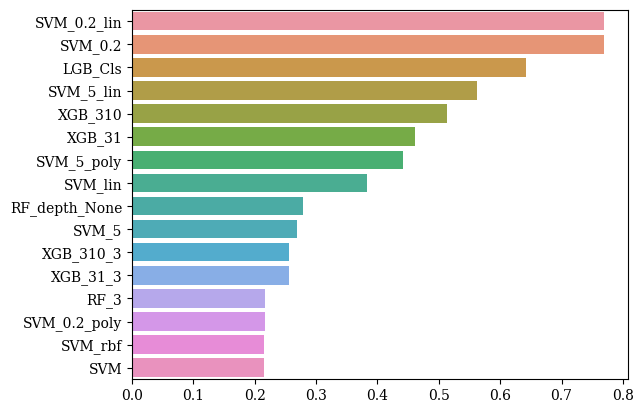

In [ ]:
weights = cv_model[0].stack_model.weights.data.detach().numpy()
for i in range(1,len(cv_model)):
  weights = np.add(cv_model[i].stack_model.weights.data.detach().numpy(),weights)

weights = weights/len(cv_model)
importance = np.array(weights.mean(axis=1))
model_name = list(model_dict.keys())
display(importance,model_name)
display(np.round(weights,decimals=2))
zipped = list(zip(model_name,importance))
sorted_zipped = sorted(zipped, key=lambda x: x[1])[::-1]
model_name, importance = zip(*sorted_zipped)
importance = np.array(importance)
sns.barplot(y=list(model_name),x=importance)
plt.show()

In [ ]:
stack_model = ML_Weighted_Model(5,2,epoch=10000,init_mode='rand',l1_norm=0)

In [ ]:

#stack_model = DecisionTreeClassifier()
cv_ensemble_model = Stack_Ensemble_Proba_Model(model_dict=cv_model, stack_model=copy.deepcopy(stack_model), stack_training_split=0.3)
# cv_ensemble_model = Mean_Ensemble_Proba_Model(cv_model)
cv_ensemble_model.fit(train_data,train_label)
# # cv_ensemble_model.fit(train_data,train_label)
# print('========== Ensemble Model ==========')
# _=model.evaluate(test_data,test_label,evaluation_fn=accuracy_score,verbose=True)
print('========== CV Ensemble Model ==========')
_=cv_ensemble_model.evaluate(test_data,test_label,evaluation_fn=accuracy_score,verbose=True)

In [ ]:
cv_ensemble_model.evaluate(train_data,train_label,accuracy_score)

In [ ]:
test_data = test_df.values[:,1:]
test_data = qt.transform(test_data)
test_pred = model.predict(test_data)
test_pred

In [ ]:
import torch